In [328]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

In [329]:
!cat /data/dlrm/binary_dataset/model_size.json

{
    "_c2": 138493,
    "_c3": 26744
}

In [330]:
import pandas as pd

users_mapping = pd.read_parquet('/data/dlrm/spark/output/models/2.parquet',engine='pyarrow')

In [331]:
users_mapping.shape

(138493, 3)

In [332]:
users_mapping

,data,id,model_count
0,97925,123067,47
1,59434,123068,47
2,94458,123069,47
3,14838,123070,47
4,72926,123071,47
5,51031,123072,47
6,112749,123073,47
7,43489,123074,47
8,59377,123075,47
9,12978,123076,47


In [333]:
(905-20)*138493 

122566305

In [334]:
5050*26744 

135057200

In [335]:
items_mapping = pd.read_parquet('/data/dlrm/spark/output/models/3.parquet',engine='pyarrow')

In [336]:
items_mapping.sort_values(by='model_count',  ascending=False)

,data,id,model_count
24283,296,1,67524
24284,356,2,66386
24285,318,3,63608
24286,593,4,63526
24287,480,5,59932
24288,260,6,54739
24289,110,7,54036
24290,589,8,52505
24291,2571,9,51581
24292,527,10,50394


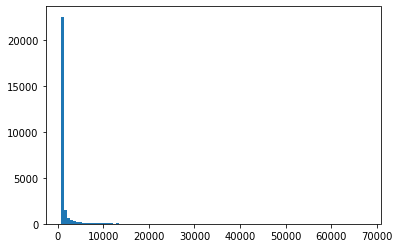

In [337]:
import matplotlib.pyplot as plt
plt.hist(items_mapping['model_count'],100);

In [338]:
np.max(items_mapping['id'])

26744

In [339]:
np.sum(items_mapping['model_count'])

39842977

In [340]:
np.sum(users_mapping['model_count'])

39842977

In [341]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [128, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "/data/dlrm/binary_dataset/"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 1
        self.hash_indices = False

In [342]:
FLAGS = flag()

print("Creating model")

model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': get_categorical_feature_sizes(FLAGS),
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
feature sizes:  [138494, 26745]
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [343]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "/workspace/dlrm/movie_lens_model-smallnet")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [138494, 26745]


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [344]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([165239, 128])

In [345]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [346]:
item_embedding = embedding[138494:]
item_embedding.shape

(26745, 128)

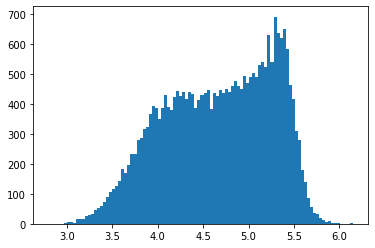

In [347]:
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [348]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [349]:
nn_to_movies = {}
movies_to_nn = {}
for _, row in items_mapping.iterrows():
    movies_to_nn[int(row['data'])] = int(row['id'])
    nn_to_movies[int(row['id'])] = int(row['data'])


In [350]:
import pandas as pd
movies = pd.read_csv("./data/ml-20m/movies.csv", index_col="movieId")

movie_ID = 1196 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Similar movies: 
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
1214 Alien (1979) Horror|Sci-Fi
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi


In [351]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
356 Forrest Gump (1994) Comedy|Drama|Romance|War
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
527 Schindler's List (1993) Drama|War
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
586 Home Alone (1990) Children|Comedy
500 Mrs. Doubtfire (1993) Comedy|Drama
5

26 Othello (1995) Drama
41 Richard III (1995) Drama|War
85 Angels and Insects (1995) Drama|Romance
1411 Hamlet (1996) Crime|Drama|Romance
892 Twelfth Night (1996) Comedy|Drama|Romance
1366 Crucible, The (1996) Drama
613 Jane Eyre (1996) Drama|Romance
92 Mary Reilly (1996) Drama|Horror|Thriller
1417 Portrait of a Lady, The (1996) Drama
83 Once Upon a Time... When We Were Colored (1995) Drama|Romance

Query:  Now and Then (1995) Children|Drama
Similar movies: 
27 Now and Then (1995) Children|Drama
351 Corrina, Corrina (1994) Comedy|Drama|Romance
179 Mad Love (1995) Drama|Romance
271 Losing Isaiah (1995) Drama
57 Home for the Holidays (1995) Drama
74 Bed of Roses (1996) Drama|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
754 Gold Diggers: The Secret of Bear Mountain (1995) Adventure|Children
340 War, The (1994) Adventure|Drama|War
375 Safe Passage (1994) Drama

Query:  Persuasion (1995) Drama|Romance
Similar movies: 
28 Persuasion (1995) Drama|Romance
35 Carrington (1995)

41 Richard III (1995) Drama|War
1050 Looking for Richard (1996) Documentary|Drama
26 Othello (1995) Drama
728 Cold Comfort Farm (1995) Comedy
85 Angels and Insects (1995) Drama|Romance
82 Antonia's Line (Antonia) (1995) Comedy|Drama
272 Madness of King George, The (1994) Comedy|Drama
1041 Secrets & Lies (1996) Drama
800 Lone Star (1996) Drama|Mystery|Western
30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) Crime|Drama

Query:  Dead Presidents (1995) Action|Crime|Drama
Similar movies: 
42 Dead Presidents (1995) Action|Crime|Drama
259 Kiss of Death (1995) Crime|Drama|Thriller
159 Clockers (1995) Crime|Drama|Mystery
493 Menace II Society (1993) Action|Crime|Drama
464 Hard Target (1993) Action|Adventure|Crime|Thriller
1382 Marked for Death (1990) Action|Drama
521 Romeo Is Bleeding (1993) Crime|Thriller
423 Blown Away (1994) Action|Thriller
210 Wild Bill (1995) Western
384 Bad Company (1995) Action|Crime|Drama

Query:  Restoration (1995) Drama
Similar movies: 
43 Restoration (1995) D

64 Two if by Sea (1996) Comedy|Romance
102 Mr. Wrong (1996) Comedy
74 Bed of Roses (1996) Drama|Romance
612 Pallbearer, The (1996) Comedy
378 Speechless (1994) Comedy|Romance
697 Feeling Minnesota (1996) Drama|Romance
656 Eddie (1996) Comedy
640 Diabolique (1996) Drama|Thriller
1167 Dear God (1996) Comedy
140 Up Close and Personal (1996) Drama|Romance

Query:  Bio-Dome (1996) Comedy
Similar movies: 
65 Bio-Dome (1996) Comedy
88 Black Sheep (1996) Comedy
135 Down Periscope (1996) Comedy
743 Spy Hard (1996) Comedy
637 Sgt. Bilko (1996) Comedy
216 Billy Madison (1995) Comedy
413 Airheads (1994) Comedy
267 Major Payne (1995) Comedy
542 Son in Law (1993) Comedy|Drama|Romance
765 Jack (1996) Comedy|Drama

Query:  Lawnmower Man 2: Beyond Cyberspace (1996) Action|Sci-Fi|Thriller
Similar movies: 
66 Lawnmower Man 2: Beyond Cyberspace (1996) Action|Sci-Fi|Thriller
737 Barb Wire (1996) Action|Sci-Fi
76 Screamers (1995) Action|Sci-Fi|Thriller
405 Highlander III: The Sorcerer (a.k.a. Highlander: Th

92 Mary Reilly (1996) Drama|Horror|Thriller
640 Diabolique (1996) Drama|Thriller
74 Bed of Roses (1996) Drama|Romance
61 Eye for an Eye (1996) Drama|Thriller
140 Up Close and Personal (1996) Drama|Romance
79 Juror, The (1996) Drama|Thriller
100 City Hall (1996) Drama|Thriller
113 Before and After (1996) Drama|Mystery
1043 To Gillian on Her 37th Birthday (1996) Drama|Romance
879 Relic, The (1997) Horror|Thriller

Query:  Vampire in Brooklyn (1995) Comedy|Horror|Romance
Similar movies: 
93 Vampire in Brooklyn (1995) Comedy|Horror|Romance
328 Tales from the Crypt Presents: Demon Knight (1995) Horror|Thriller
177 Lord of Illusions (1995) Horror
464 Hard Target (1993) Action|Adventure|Crime|Thriller
606 Candyman: Farewell to the Flesh (1995) Fantasy|Horror
548 Terminal Velocity (1994) Action|Mystery|Thriller
416 Bad Girls (1994) Western
122 Boomerang (1992) Comedy|Romance
737 Barb Wire (1996) Action|Sci-Fi
544 Striking Distance (1993) Action|Crime

Query:  Beautiful Girls (1996) Comedy|Dram

108 Catwalk (1996) Documentary
138 Neon Bible, The (1995) Drama
843 Lotto Land (1995) Drama
1368 Forbidden Christ, The (Cristo proibito, Il) (1950) Drama
1400 Somebody is Waiting (1996) Drama
855 Every Other Weekend (Un week-end sur deux) (1990) Drama
1309 Parallel Sons (1995) Drama|Romance
821 Crude Oasis, The (1995) Drama|Romance
795 Somebody to Love (1994) Drama
873 Shadow of Angels (Schatten der Engel) (1976) Drama

Query:  Headless Body in Topless Bar (1995) Comedy|Drama|Thriller
Similar movies: 
109 Headless Body in Topless Bar (1995) Comedy|Drama|Thriller
4882 Ouch (Aïe) (2000) Comedy
3583 Black Tights (1-2-3-4 ou Les Collants noirs) (1960) Drama|Musical
5877 Smokers Only (Vagón Fumador) (2001) Drama|Romance
6504 Gasoline (Benzina) (2001) Crime
8806 Masks (Masques) (1987) Thriller
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
32354 Free Radicals (Böse Zellen) (2003) Drama
5757 History of Kim Skov (Historien om Kim Skov) (1981) Documentary|Drama
7537 Du côté de la cô

132 Jade (1995) Thriller
259 Kiss of Death (1995) Crime|Drama|Thriller
521 Romeo Is Bleeding (1993) Crime|Thriller
490 Malice (1993) Thriller
540 Sliver (1993) Thriller
422 Blink (1994) Thriller
548 Terminal Velocity (1994) Action|Mystery|Thriller
640 Diabolique (1996) Drama|Thriller
71 Fair Game (1995) Action
257 Just Cause (1995) Mystery|Thriller

Query:  Nueba Yol (1995) Comedy|Drama
Similar movies: 
133 Nueba Yol (1995) Comedy|Drama
654 And Nobody Weeps for Me (Und keiner weint mir nach) (1996) Drama|Romance
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
644 Happy Weekend (1996) Comedy
3583 Black Tights (1-2-3-4 ou Les Collants noirs) (1960) Drama|Musical
655 My Mother's Courage (Mutters Courage) (1995) Comedy
642 Roula (1995) Drama
772 Quartier Mozart (1992) Comedy
859 Hippie Revolution, The (1996) Documentary
739 Honey Moon (Honigmond) (1996) Comedy

Query:  Sonic Outlaws (1995) Documentary
Similar movies: 
134 Sonic Outlaws (1995) Documentary
758 Jar, The (Khomreh) (

159 Clockers (1995) Crime|Drama|Mystery
521 Romeo Is Bleeding (1993) Crime|Thriller
42 Dead Presidents (1995) Action|Crime|Drama
373 Red Rock West (1992) Thriller
428 Bronx Tale, A (1993) Drama
493 Menace II Society (1993) Action|Crime|Drama
229 Death and the Maiden (1994) Drama|Thriller
259 Kiss of Death (1995) Crime|Drama|Thriller
352 Crooklyn (1994) Comedy|Drama
354 Cobb (1994) Drama

Query:  Congo (1995) Action|Adventure|Mystery|Sci-Fi
Similar movies: 
160 Congo (1995) Action|Adventure|Mystery|Sci-Fi
185 Net, The (1995) Action|Crime|Thriller
442 Demolition Man (1993) Action|Adventure|Sci-Fi
173 Judge Dredd (1995) Action|Crime|Sci-Fi
316 Stargate (1994) Action|Adventure|Sci-Fi
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
292 Outbreak (1995) Action|Drama|Sci-Fi|Thriller
196 Species (1995) Horror|Sci-Fi
172 Johnny Mnemonic (1995) Action|Sci-Fi|Thriller
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller

Query:  Crimson Tide (1995) Drama|Thriller|War
Similar movi

180 Mallrats (1995) Comedy|Romance
69 Friday (1995) Comedy
441 Dazed and Confused (1993) Comedy
2318 Happiness (1998) Comedy|Drama

Query:  Living in Oblivion (1995) Comedy
Similar movies: 
176 Living in Oblivion (1995) Comedy
125 Flirting With Disaster (1996) Comedy
535 Short Cuts (1993) Drama
322 Swimming with Sharks (1995) Comedy|Drama
574 Spanking the Monkey (1994) Comedy|Drama
1171 Bob Roberts (1992) Comedy
501 Naked (1993) Drama
194 Smoke (1995) Comedy|Drama
562 Welcome to the Dollhouse (1995) Comedy|Drama
162 Crumb (1994) Documentary

Query:  Lord of Illusions (1995) Horror
Similar movies: 
177 Lord of Illusions (1995) Horror
188 Prophecy, The (1995) Fantasy|Horror|Mystery
328 Tales from the Crypt Presents: Demon Knight (1995) Horror|Thriller
332 Village of the Damned (1995) Horror|Sci-Fi
366 Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994) Drama|Horror|Mystery|Thriller
606 Candyman: Farewell to the Flesh (1995) Fantasy|Horror
330 Tales from

202 Total Eclipse (1995) Drama|Romance
178 Love & Human Remains (1993) Comedy|Drama
2626 Edge of Seventeen (1998) Comedy|Drama|Romance
1063 Johns (1996) Drama
896 Wild Reeds (Les roseaux sauvages) (1994) Drama
526 Savage Nights (Nuits fauves, Les) (1992) Drama
1696 Bent (1997) Drama|War
359 I Like It Like That (1994) Comedy|Drama|Romance
2388 Steam: The Turkish Bath (Hamam) (1997) Drama|Romance
242 Farinelli: il castrato (1994) Drama|Musical

Query:  To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
Similar movies: 
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
276 Milk Money (1994) Comedy|Romance
585 Brady Bunch Movie, The (1995) Comedy
327 Tank Girl (1995) Action|Comedy|Sci-Fi
351 Corrina, Corrina (1994) Comedy|Drama|Romance
419 Beverly Hillbillies, The (1993) Comedy
218 Boys on the Side (1995) Comedy|Drama
372 Reality Bites (1994) Comedy|Drama|Romance
60 Indian in the Cupboard, The (1995) Adventure|Children|Fantasy
542 Son in Law (1993) Comedy|Drama

218 Boys on the Side (1995) Comedy|Drama
195 Something to Talk About (1995) Comedy|Drama|Romance
371 Paper, The (1994) Comedy|Drama
4 Waiting to Exhale (1995) Comedy|Drama|Romance
477 What's Love Got to Do with It? (1993) Drama|Musical
276 Milk Money (1994) Comedy|Romance
222 Circle of Friends (1995) Drama|Romance
46 How to Make an American Quilt (1995) Drama|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
378 Speechless (1994) Comedy|Romance

Query:  Cure, The (1995) Drama
Similar movies: 
219 Cure, The (1995) Drama
754 Gold Diggers: The Secret of Bear Mountain (1995) Adventure|Children
238 Far From Home: The Adventures of Yellow Dog (1995) Adventure|Children
304 Roommates (1995) Comedy|Drama
271 Losing Isaiah (1995) Drama
460 Getting Even with Dad (1994) Comedy
340 War, The (1994) Adventure|Drama|War
528 Scout, The (1994) Comedy|Drama
241 Fluke (1995) Children|Drama
200 Tie That Binds, The (1995) Thriller

Query:  Castle Freak (1995) Horror
Similar movies: 
220 Castle 

244 Gumby: The Movie (1995) Animation|Children
146 Amazing Panda Adventure, The (1995) Adventure|Children
888 Land Before Time III: The Time of the Great Giving (1995) Adventure|Animation|Children|Musical
8 Tom and Huck (1995) Adventure|Children
558 Pagemaster, The (1994) Action|Adventure|Animation|Children|Fantasy
754 Gold Diggers: The Secret of Bear Mountain (1995) Adventure|Children
126 NeverEnding Story III, The (1994) Adventure|Children|Fantasy
238 Far From Home: The Adventures of Yellow Dog (1995) Adventure|Children
13 Balto (1995) Adventure|Animation|Children
343 Baby-Sitters Club, The (1995) Children

Query:  Glass Shield, The (1994) Crime|Drama
Similar movies: 
245 Glass Shield, The (1994) Crime|Drama
297 Panther (1995) Drama
283 New Jersey Drive (1995) Crime|Drama
406 Federal Hill (1994) Drama
335 Underneath (1995) Mystery|Thriller
209 White Man's Burden (1995) Drama
359 I Like It Like That (1994) Comedy|Drama|Romance
352 Crooklyn (1994) Comedy|Drama
391 Jason's Lyric (1994) 

279 My Family (1995) Drama
77 Nico Icon (1995) Documentary
406 Federal Hill (1994) Drama
846 Flirt (1995) Drama
461 Go Fish (1994) Drama|Romance
523 Ruby in Paradise (1993) Drama

Query:  Love Affair (1994) Drama|Romance
Similar movies: 
270 Love Affair (1994) Drama|Romance
195 Something to Talk About (1995) Comedy|Drama|Romance
378 Speechless (1994) Comedy|Romance
271 Losing Isaiah (1995) Drama
182 Moonlight and Valentino (1995) Drama|Romance
294 Perez Family, The (1995) Comedy|Romance
304 Roommates (1995) Comedy|Drama
554 Trial by Jury (1994) Crime|Drama|Thriller
472 I'll Do Anything (1994) Comedy|Drama
289 Only You (1994) Comedy|Romance

Query:  Losing Isaiah (1995) Drama
Similar movies: 
271 Losing Isaiah (1995) Drama
510 Poetic Justice (1993) Drama
4 Waiting to Exhale (1995) Comedy|Drama|Romance
340 War, The (1994) Adventure|Drama|War
304 Roommates (1995) Comedy|Drama
270 Love Affair (1994) Drama|Romance
354 Cobb (1994) Drama
528 Scout, The (1994) Comedy|Drama
27 Now and Then (199

294 Perez Family, The (1995) Comedy|Romance
472 I'll Do Anything (1994) Comedy|Drama
753 Month by the Lake, A (1995) Comedy|Drama|Romance
206 Unzipped (1995) Documentary
278 Miami Rhapsody (1995) Comedy
254 Jefferson in Paris (1995) Drama
279 My Family (1995) Drama
452 Widows' Peak (1994) Drama
57 Home for the Holidays (1995) Drama
287 Nina Takes a Lover (1994) Comedy|Romance

Query:  Pyromaniac's Love Story, A (1995) Comedy|Romance
Similar movies: 
295 Pyromaniac's Love Story, A (1995) Comedy|Romance
536 Simple Twist of Fate, A (1994) Drama
378 Speechless (1994) Comedy|Romance
287 Nina Takes a Lover (1994) Comedy|Romance
472 I'll Do Anything (1994) Comedy|Drama
304 Roommates (1995) Comedy|Drama
294 Perez Family, The (1995) Comedy|Romance
453 For Love or Money (1993) Comedy|Romance
179 Mad Love (1995) Drama|Romance
691 Mrs. Winterbourne (1996) Comedy|Romance

Query:  Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
Similar movies: 
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
47 

480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller

Query:  Shallow Grave (1994) Comedy|Drama|Thriller
Similar movies: 
319 Shallow Grave (1994) Comedy|Drama|Thriller
247 Heavenly Creatures (1994) Crime|Drama
194 Smoke (1995) Comedy|Drama
535 Short Cuts (1993) Drama
482 Killing Zoe (1994) Crime|Drama|Thriller
555 True Romance (1993) Crime|Thriller
481 Kalifornia (1993) Drama|Thriller
475 In the Name of the Father (1993) Drama
538 Six Degrees of Separation (1993) Drama
290 Once Were Warriors (1994) Crime|Drama

Query:  Suture (1993) Film-Noir|Thriller
Similar movies: 
320 Suture (1993) Film-Noir|Thriller
335 Underneath (1995) Mystery|Thriller
496 What Happened Was... (1994) Comedy|Drama|Romance|Thriller
561 Killer (Bulletproof Heart) (1994) Drama|Thriller
503 New Age, The (1994) Drama
77 Nico Icon (1995) Documentary
184 Nadja (1994) Drama
268 Little Odessa (1994) Crime|Drama
846 Flirt (1995) Drama
341 Double Happiness (1994) Drama

Query:  Strawberry and Chocolate (Fresa y chocol

335 Underneath (1995) Mystery|Thriller
320 Suture (1993) Film-Noir|Thriller
373 Red Rock West (1992) Thriller
521 Romeo Is Bleeding (1993) Crime|Thriller
245 Glass Shield, The (1994) Crime|Drama
496 What Happened Was... (1994) Comedy|Drama|Romance|Thriller
600 Love and a .45 (1994) Action|Comedy|Crime
561 Killer (Bulletproof Heart) (1994) Drama|Thriller
268 Little Odessa (1994) Crime|Drama
178 Love & Human Remains (1993) Comedy|Drama

Query:  Walking Dead, The (1995) Drama|War
Similar movies: 
336 Walking Dead, The (1995) Drama|War
554 Trial by Jury (1994) Crime|Drama|Thriller
391 Jason's Lyric (1994) Crime|Drama
251 Hunted, The (1995) Action
226 Dream Man (1995) Thriller
297 Panther (1995) Drama
200 Tie That Binds, The (1995) Thriller
458 Geronimo: An American Legend (1993) Drama|Western
113515 Snake River Desperadoes (1951) Western
107551 Snow Beast (2011)  Drama|Sci-Fi|Thriller

Query:  What's Eating Gilbert Grape (1993) Drama
Similar movies: 
337 What's Eating Gilbert Grape (1993) 

359 I Like It Like That (1994) Comedy|Drama|Romance
269 My Crazy Life (Mi vida loca) (1993) Drama
496 What Happened Was... (1994) Comedy|Drama|Romance|Thriller
206 Unzipped (1995) Documentary
131 Frankie Starlight (1995) Drama|Romance
245 Glass Shield, The (1994) Crime|Drama
406 Federal Hill (1994) Drama
375 Safe Passage (1994) Drama
341 Double Happiness (1994) Drama
1063 Johns (1996) Drama

Query:  I Love Trouble (1994) Action|Comedy
Similar movies: 
360 I Love Trouble (1994) Action|Comedy
378 Speechless (1994) Comedy|Romance
289 Only You (1994) Comedy|Romance
516 Renaissance Man (1994) Comedy|Drama
195 Something to Talk About (1995) Comedy|Drama|Romance
122 Boomerang (1992) Comedy|Romance
544 Striking Distance (1993) Action|Crime
548 Terminal Velocity (1994) Action|Mystery|Thriller
415 Another Stakeout (1993) Comedy|Thriller
71 Fair Game (1995) Action

Query:  It Could Happen to You (1994) Comedy|Drama|Romance
Similar movies: 
361 It Could Happen to You (1994) Comedy|Drama|Romance
19

723 Two Friends (1986) Drama
101833 About Face: Supermodels Then and Now (2012) Comedy|Documentary
629 Rude (1995) Drama

Query:  River Wild, The (1994) Action|Thriller
Similar movies: 
376 River Wild, The (1994) Action|Thriller
802 Phenomenon (1996) Drama|Romance
350 Client, The (1994) Drama|Mystery|Thriller
3 Grumpier Old Men (1995) Comedy|Romance
5 Father of the Bride Part II (1995) Comedy
225 Disclosure (1994) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
440 Dave (1993) Comedy|Romance
736 Twister (1996) Action|Adventure|Romance|Thriller
95 Broken Arrow (1996) Action|Adventure|Thriller

Query:  Speed (1994) Action|Romance|Thriller
Similar movies: 
377 Speed (1994) Action|Romance|Thriller
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
10 GoldenEye (1995) Action|Adventure|Thriller
457 Fugiti

400 Homage (1995) Drama
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
644 Happy Weekend (1996) Comedy
654 And Nobody Weeps for Me (Und keiner weint mir nach) (1996) Drama|Romance
1141 Last Call (Hoogste tijd) (1995) Drama
655 My Mother's Courage (Mutters Courage) (1995) Comedy
684 Windows (1980) Drama
859 Hippie Revolution, The (1996) Documentary
693 Under the Domim Tree (Etz Hadomim Tafus) (1994) Drama

Query:  Mirage (1995) Action|Thriller
Similar movies: 
401 Mirage (1995) Action|Thriller
112501 Kabhi Haan Kabhi Naa (1994) Comedy|Drama|Musical|Romance
130054 Pauline détective (2012) Comedy
105347 Quand je serai petit (2012) Drama
111100 Three Faces East (1930) Drama|Mystery|War
127058 Godspeed You! Black Emperor (1976) Documentary
84178 Jew Süss (Jud Süß) (1940) Drama
125539 He Who Dares (2014) Action
109804 God's Gun (1976) Western
127054 Gertie the Dinosaur (1914) Animation|Children|Comedy

Query:  Open Season (1996) Com

427 Boxing Helena (1993) Drama|Mystery|Romance|Thriller
521 Romeo Is Bleeding (1993) Crime|Thriller
540 Sliver (1993) Thriller
537 Sirens (1994) Drama
305 Ready to Wear (Pret-A-Porter) (1994) Comedy
444 Even Cowgirls Get the Blues (1993) Comedy|Romance
373 Red Rock West (1992) Thriller
218 Boys on the Side (1995) Comedy|Drama
132 Jade (1995) Thriller
482 Killing Zoe (1994) Crime|Drama|Thriller

Query:  Bronx Tale, A (1993) Drama
Similar movies: 
428 Bronx Tale, A (1993) Drama
431 Carlito's Way (1993) Crime|Drama
16 Casino (1995) Crime|Drama
159 Clockers (1995) Crime|Drama|Mystery
493 Menace II Society (1993) Action|Crime|Drama
475 In the Name of the Father (1993) Drama
147 Basketball Diaries, The (1995) Drama
280 Murder in the First (1995) Drama|Thriller
1095 Glengarry Glen Ross (1992) Drama
628 Primal Fear (1996) Crime|Drama|Mystery|Thriller

Query:  Cabin Boy (1994) Comedy
Similar movies: 
429 Cabin Boy (1994) Comedy
473 In the Army Now (1994) Comedy|War
2249 My Blue Heaven (1990) Co

444 Even Cowgirls Get the Blues (1993) Comedy|Romance
305 Ready to Wear (Pret-A-Porter) (1994) Comedy
218 Boys on the Side (1995) Comedy|Drama
206 Unzipped (1995) Documentary
427 Boxing Helena (1993) Drama|Mystery|Romance|Thriller
148 Awfully Big Adventure, An (1995) Drama
461 Go Fish (1994) Drama|Romance
537 Sirens (1994) Drama
278 Miami Rhapsody (1995) Comedy
369 Mrs. Parker and the Vicious Circle (1994) Drama

Query:  Fatal Instinct (1993) Comedy
Similar movies: 
445 Fatal Instinct (1993) Comedy
489 Made in America (1993) Comedy
415 Another Stakeout (1993) Comedy|Thriller
234 Exit to Eden (1994) Comedy
248 Houseguest (1994) Comedy
122 Boomerang (1992) Comedy|Romance
278 Miami Rhapsody (1995) Comedy
174 Jury Duty (1995) Comedy
312 Stuart Saves His Family (1995) Comedy
275 Mixed Nuts (1994) Comedy

Query:  Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
Similar movies: 
446 Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
232 Eat Drink Man Woman (Yin shi nan nu)

467 Live Nude Girls (1995) Comedy
102 Mr. Wrong (1996) Comedy
1113 Associate, The (1996) Comedy
984 Pompatus of Love, The (1996) Comedy|Drama
612 Pallbearer, The (1996) Comedy
64 Two if by Sea (1996) Comedy|Romance
664 Faithful (1996) Comedy
118 If Lucy Fell (1996) Comedy|Romance
725 Great White Hype, The (1996) Comedy
75 Big Bully (1996) Comedy|Drama

Query:  Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
Similar movies: 
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
497 Much Ado About Nothing (1993) Comedy|Romance
151 Rob Roy (1995) Action|Drama|Romance|War
17 Sense and Sensibility (1995) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
236 French Kiss (1995) Action|Comedy|Romance
342 Muriel's Wedding (1994) Comedy
105 Bridges of Madison County, The (1995) Drama|Romance
272 Madness of King George, The (1994) Comedy|Drama

Query:  House of the Spiri

492 Manhattan Murder Mystery (1993) Comedy|Mystery
1701 Deconstructing Harry (1997) Comedy|Drama
2065 Purple Rose of Cairo, The (1985) Comedy|Drama|Fantasy|Romance
1057 Everyone Says I Love You (1996) Comedy|Musical|Romance
2356 Celebrity (1998) Comedy
348 Bullets Over Broadway (1994) Comedy
2973 Crimes and Misdemeanors (1989) Comedy|Crime|Drama
2290 Stardust Memories (1980) Comedy|Drama
2750 Radio Days (1987) Comedy|Drama
3129 Sweet and Lowdown (1999) Comedy|Drama

Query:  Menace II Society (1993) Action|Crime|Drama
Similar movies: 
493 Menace II Society (1993) Action|Crime|Drama
42 Dead Presidents (1995) Action|Crime|Drama
69 Friday (1995) Comedy
428 Bronx Tale, A (1993) Drama
159 Clockers (1995) Crime|Drama|Mystery
456 Fresh (1994) Crime|Drama|Thriller
431 Carlito's Way (1993) Crime|Drama
175 Kids (1995) Drama
358 Higher Learning (1995) Drama
1785 King of New York (1990) Crime|Thriller

Query:  Executive Decision (1996) Action|Adventure|Thriller
Similar movies: 
494 Executive Decisi

508 Philadelphia (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
300 Quiz Show (1994) Drama
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
454 Firm, The (1993) Drama|Thriller
266 Legends of the Fall (1994) Drama|Romance|War|Western
509 Piano, The (1993) Drama|Romance
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
150 Apollo 13 (1995) Adventure|Drama|IMAX
36 Dead Man Walking (1995) Crime|Drama

Query:  Piano, The (1993) Drama|Romance
Similar movies: 
509 Piano, The (1993) Drama|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
508 Philadelphia (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
342 Muriel's Wedding (1994) Comedy
17 Sense and Sensibility (1995) Drama|Romance
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
105 Bridges of Madison County, The (1995) Drama|Romance
282 Nell (1994) Drama
497 Much Ado About Nothing (1993) Comedy|Romance

Query:  Poetic Justice (1993) Drama
Similar movies: 
510 Poetic Justice (1993) Drama
271 Losing

531 Secret Garden, The (1993) Children|Drama
262 Little Princess, A (1995) Children|Drama
616 Aristocats, The (1970) Animation|Children
362 Jungle Book, The (1994) Adventure|Children|Romance
60 Indian in the Cupboard, The (1995) Adventure|Children|Fantasy
261 Little Women (1994) Drama
277 Miracle on 34th Street (1994) Drama
351 Corrina, Corrina (1994) Comedy|Drama|Romance
1013 Parent Trap, The (1961) Children|Comedy|Romance
421 Black Beauty (1994) Adventure|Children|Drama

Query:  Serial Mom (1994) Comedy|Crime|Horror
Similar movies: 
532 Serial Mom (1994) Comedy|Crime|Horror
382 Wolf (1994) Drama|Horror|Romance|Thriller
550 Threesome (1994) Comedy|Romance
481 Kalifornia (1993) Drama|Thriller
218 Boys on the Side (1995) Comedy|Drama
234 Exit to Eden (1994) Comedy
427 Boxing Helena (1993) Drama|Mystery|Romance|Thriller
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
540 Sliver (1993) Thriller
122 Boomerang (1992) Comedy|Romance

Query:  Shadow, The (1994) Action|Adven

547 Surviving the Game (1994) Action|Adventure|Thriller
479 Judgment Night (1993) Action|Crime|Thriller
1382 Marked for Death (1990) Action|Drama
504 No Escape (1994) Action|Drama|Sci-Fi
459 Getaway, The (1994) Action|Adventure|Crime|Drama|Romance|Thriller
809 Fled (1996) Action|Adventure
1379 Young Guns II (1990) Action|Western
438 Cowboy Way, The (1994) Action|Comedy|Drama
517 Rising Sun (1993) Action|Drama|Mystery
692 Solo (1996) Action|Sci-Fi|Thriller

Query:  Terminal Velocity (1994) Action|Mystery|Thriller
Similar movies: 
548 Terminal Velocity (1994) Action|Mystery|Thriller
544 Striking Distance (1993) Action|Crime
227 Drop Zone (1994) Action|Thriller
464 Hard Target (1993) Action|Adventure|Crime|Thriller
533 Shadow, The (1994) Action|Adventure|Fantasy|Mystery
20 Money Train (1995) Action|Comedy|Crime|Drama|Thriller
71 Fair Game (1995) Action
360 I Love Trouble (1994) Action|Comedy
415 Another Stakeout (1993) Comedy|Thriller
9 Sudden Death (1995) Action

Query:  Thirty-Two Short

309 Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994) Drama
526 Savage Nights (Nuits fauves, Les) (1992) Drama
108551 String, The (Le fil) (2009) Drama
1184 Mediterraneo (1991) Comedy|Drama
583 Dear Diary (Caro Diario) (1994) Comedy|Drama
2251 Cabinet of Dr. Ramirez, The (1991) Comedy
579 Escort, The (Scorta, La) (1993) Crime|Thriller
389 Colonel Chabert, Le (1994) Drama|Romance|War

Query:  Spanking the Monkey (1994) Comedy|Drama
Similar movies: 
574 Spanking the Monkey (1994) Comedy|Drama
1171 Bob Roberts (1992) Comedy
206 Unzipped (1995) Documentary
125 Flirting With Disaster (1996) Comedy
176 Living in Oblivion (1995) Comedy
187 Party Girl (1995) Comedy
417 Barcelona (1994) Comedy|Romance
322 Swimming with Sharks (1995) Comedy|Drama
2282 Pecker (1998) Comedy|Drama
1392 Citizen Ruth (1996) Comedy|Drama

Query:  Little Rascals, The (1994) Children|Comedy
Similar movies: 
575 Little Rascals, The (1994) Children|Comedy
54 Big Green, The (1995) Children|Comedy
250 Heavyweig

590 Dances with Wolves (1990) Adventure|Drama|Western
597 Pretty Woman (1990) Comedy|Romance
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
457 Fugitive, The (1993) Thriller
377 Speed (1994) Action|Romance|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
110 Braveheart (1995) Action|Drama|War
150 Apollo 13 (1995) Adventure|Drama|IMAX
592 Batman (1989) Action|Crime|Thriller
208 Waterworld (1995) Action|Adventure|Sci-Fi

Query:  Tough and Deadly (1995) Action|Drama|Thriller
Similar movies: 
591 Tough and Deadly (1995) Action|Drama|Thriller
128443 La petite reine (2014) Drama
815 Power 98 (1996) Action|Mystery|Thriller
1557 Squeeze (1997) Drama
105583 Voodoo Dawn (1991) Horror
116833 Son of the White Mare (1981) Adventure|Animation|Fantasy
104233 Cat and the Canary, The (1939) Comedy|Horror|Mystery
129391 If You Don't Stop It... You'll Go Blind!!! (1975) Comedy
115283 Purple Ball, The (Lilovyy shar) (1987) Fantasy|Sci-Fi
814 Boy Called Hate, A (1995) Drama

604 Criminals (1996) Documentary
108775 Striking Range (2006) Action|Thriller
97899 Nightmaster (Watch the Shadows Dance) (1987) Action
97897 Kounterfeit (1996) Action|Crime|Thriller
131180 Dead Rising: Watchtower (2015) Action|Horror|Thriller
101388 Colder Kind of Death, A (2001) Crime|Drama|Mystery
122942 The Identical (2014) Drama
119303 The Walking Stick (1970) Crime|Drama|Romance
117504 Crackers (1984) Action|Comedy|Crime|Thriller
119137 The Last Train through Harecastle Tunnel (1969) Drama

Query:  One Fine Day (1996) Drama|Romance
Similar movies: 
605 One Fine Day (1996) Drama|Romance
1457 Fools Rush In (1997) Comedy|Drama|Romance
140 Up Close and Personal (1996) Drama|Romance
74 Bed of Roses (1996) Drama|Romance
1353 Mirror Has Two Faces, The (1996) Comedy|Drama|Romance
1043 To Gillian on Her 37th Birthday (1996) Drama|Romance
1363 Preacher's Wife, The (1996) Drama
697 Feeling Minnesota (1996) Drama|Romance
1399 Marvin's Room (1996) Drama
1409 Michael (1996) Comedy|Drama|Fantas

618 Two Much (1995) Comedy|Romance
664 Faithful (1996) Comedy
795 Somebody to Love (1994) Drama
638 Jack and Sarah (1995) Romance
726 Last Dance (1996) Drama
847 Big Squeeze, The (1996) Comedy|Drama
67 Two Bits (1995) Drama
1400 Somebody is Waiting (1996) Drama
656 Eddie (1996) Comedy
118 If Lucy Fell (1996) Comedy|Romance

Query:  Ed (1996) Comedy
Similar movies: 
619 Ed (1996) Comedy
656 Eddie (1996) Comedy
102 Mr. Wrong (1996) Comedy
710 Celtic Pride (1996) Comedy
75 Big Bully (1996) Comedy|Drama
833 High School High (1996) Comedy
747 Stupids, The (1996) Comedy
609 Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
274 Man of the House (1995) Comedy
818 Very Brady Sequel, A (1996) Comedy

Query:  Scream of Stone (Cerro Torre: Schrei aus Stein) (1991) Drama
Similar movies: 
620 Scream of Stone (Cerro Torre: Schrei aus Stein) (1991) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
76720 Movie Crazy (1932) Comedy|Romance
774 Wend Kuuni (a.k.a. God's Gift) (1982) Dr

644 Happy Weekend (1996) Comedy
1141 Last Call (Hoogste tijd) (1995) Drama
642 Roula (1995) Drama
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
6677 Predictions of Fire (Prerokbe Ognja) (1996) Documentary
772 Quartier Mozart (1992) Comedy
859 Hippie Revolution, The (1996) Documentary
739 Honey Moon (Honigmond) (1996) Comedy
675 Hostile Intentions (1994) Action|Drama|Thriller

Query:  Nelly & Monsieur Arnaud (1995) Drama
Similar movies: 
645 Nelly & Monsieur Arnaud (1995) Drama
1163 Mina Tannenbaum (1994) Drama
715 Horseman on the Roof, The (Hussard sur le toit, Le) (1995) Drama|Romance
214 Before the Rain (Pred dozhdot) (1994) Drama|War
526 Savage Nights (Nuits fauves, Les) (1992) Drama
1406 Judgement in Stone, A (Cérémonie, La) (1995) Drama
264 Enfer, L' (1994) Drama
53 Lamerica (1994) Adventure|Drama
389 Colonel Chabert, Le (1994) Drama|Romance|War
59 Confessional, The (Confessionnal, Le) (1995) Drama|Mystery

646
Query:  C

1071 For the Moment (1994) Romance|War
819 Stefano Quantestorie (1993) Comedy|Drama
843 Lotto Land (1995) Drama
795 Somebody to Love (1994) Drama

Query:  James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
Similar movies: 
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
107 Muppet Treasure Island (1996) Adventure|Children|Comedy|Musical
783 Hunchback of Notre Dame, The (1996) Animation|Children|Drama|Musical|Romance
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical
837 Matilda (1996) Children|Comedy|Fantasy
1282 Fantasia (1940) Animation|Children|Fantasy|Musical
596 Pinocchio (1940) Animation|Children|Fantasy|Musical
1367 101 Dalmatians (1996) Adventure|Children|Comedy
1029 Dumbo (1941) Animation|Children|Drama|Musical
1022 Cinderella (1950) Animation|Children|Fantasy|Musical|Romance

Query:  Fear (1996) Thriller
Similar movies: 
662 Fear (1996) Thriller
61 Eye for an Eye (1996) Drama|Thriller
78

685 It's My Party (1996) Drama
1535 Love! Valour! Compassion! (1997) Drama|Romance
896 Wild Reeds (Les roseaux sauvages) (1994) Drama
1137 Hustler White (1996) Romance
1063 Johns (1996) Drama
1471 Boys Life 2 (1997) Drama
831 Stonewall (1995) Drama
2626 Edge of Seventeen (1998) Comedy|Drama|Romance
137 Man of the Year (1995) Documentary
324 Sum of Us, The (1994) Comedy|Drama

686
Query:  Country Life (1994) Drama|Romance
Similar movies: 
687 Country Life (1994) Drama|Romance
167 Feast of July (1995) Drama
623 Modern Affair, A (1995) Romance
723 Two Friends (1986) Drama
679 Run of the Country, The (1995) Drama
576 Fausto (1993) Comedy
607 Century (1993) Drama
753 Month by the Lake, A (1995) Comedy|Drama|Romance
884 Sweet Nothing (1996) Drama
1384 Substance of Fire, The (1996) Drama

Query:  Operation Dumbo Drop (1995) Action|Adventure|Comedy|War
Similar movies: 
688 Operation Dumbo Drop (1995) Action|Adventure|Comedy|War
258 Kid in King Arthur's Court, A (1995) Adventure|Children|Comedy

712 Captives (1994) Crime|Drama|Romance|Thriller
630 Carried Away (1996) Drama|Romance
660 August (1996) Drama
795 Somebody to Love (1994) Drama
67 Two Bits (1995) Drama
138 Neon Bible, The (1995) Drama
884 Sweet Nothing (1996) Drama
1308 I Shot a Man in Vegas (1995) Comedy
895 Venice/Venice (1992) Drama
713 Of Love and Shadows (1994) Drama

Query:  Of Love and Shadows (1994) Drama
Similar movies: 
713 Of Love and Shadows (1994) Drama
797 Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991) Comedy
90 Journey of August King, The (1995) Drama
795 Somebody to Love (1994) Drama
660 August (1996) Drama
601 Wooden Man's Bride, The (Yan shen) (1994) Drama
1368 Forbidden Christ, The (Cristo proibito, Il) (1950) Drama
890 Baton Rouge (Bâton rouge) (1988) Thriller
1071 For the Moment (1994) Romance|War
827 Convent, The (O Convento) (1995) Drama

Query:  Dead Man (1995) Drama|Mystery|Western
Similar movies: 
714 Dead Man (1995) Drama|Mystery|Western
1175 Delicatessen 

739 Honey Moon (Honigmond) (1996) Comedy
642 Roula (1995) Drama
3583 Black Tights (1-2-3-4 ou Les Collants noirs) (1960) Drama|Musical
1141 Last Call (Hoogste tijd) (1995) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
644 Happy Weekend (1996) Comedy
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
89549 A Via Láctea (2007) Drama
655 My Mother's Courage (Mutters Courage) (1995) Comedy
93667 Thousand Months, A (Mille mois) (2003) Drama

740
Query:  Ghost in the Shell (Kôkaku kidôtai) (1995) Animation|Sci-Fi
Similar movies: 
741 Ghost in the Shell (Kôkaku kidôtai) (1995) Animation|Sci-Fi
1274 Akira (1988) Action|Adventure|Animation|Sci-Fi
2810 Perfect Blue (1997) Animation|Horror|Mystery|Thriller
6283 Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku no Tobira) (2001) Action|Animation|Sci-Fi|Thriller
3000 Princess Mononoke (Mononoke-hime) (1997) Action|Adventure|Animation|Drama|Fantasy
29 City of Lost Children, The (Cité des enfants perdus, La) (1995) Adventure|Drama|Fantas

767 Grass Harp, The (1995) Comedy|Drama
1384 Substance of Fire, The (1996) Drama
90 Journey of August King, The (1995) Drama
1531 Losing Chase (1996) Drama
1038 Unhook the Stars (1996) Drama
1045 Love Is All There Is (1996) Comedy|Drama
884 Sweet Nothing (1996) Drama
197 Stars Fell on Henrietta, The (1995) Drama
55 Georgia (1995) Drama
862 Manny & Lo (1996) Drama

Query:  Someone Else's America (1995) Drama
Similar movies: 
768 Someone Else's America (1995) Drama
654 And Nobody Weeps for Me (Und keiner weint mir nach) (1996) Drama|Romance
699 To Cross the Rubicon (1991) Drama
655 My Mother's Courage (Mutters Courage) (1995) Comedy
1109 Charm's Incidents (Charms Zwischenfälle) (1996) Drama
133 Nueba Yol (1995) Comedy|Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
1141 Last Call (Hoogste tijd) (1995) Drama
642 Roula (1995) Drama
772 Quartier Mozart (1992) Comedy

Query:  Marlene Dietrich: Shadow and Light (1996) Documentary
Similar movies: 
769 Marlene Dietrich: Shadow and Light (

782 Fan, The (1996) Drama|Thriller
798 Daylight (1996) Action|Adventure|Drama|Thriller
996 Last Man Standing (1996) Action|Crime|Drama|Thriller
662 Fear (1996) Thriller
9 Sudden Death (1995) Action
1488 Devil's Own, The (1997) Action|Drama|Thriller
61 Eye for an Eye (1996) Drama|Thriller
1061 Sleepers (1996) Thriller
1432 Metro (1997) Action|Comedy|Crime|Drama|Thriller
79 Juror, The (1996) Drama|Thriller

Query:  Hunchback of Notre Dame, The (1996) Animation|Children|Drama|Musical|Romance
Similar movies: 
783 Hunchback of Notre Dame, The (1996) Animation|Children|Drama|Musical|Romance
48 Pocahontas (1995) Animation|Children|Drama|Musical|Romance
596 Pinocchio (1940) Animation|Children|Fantasy|Musical
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
594 Snow White and the Seven Dwarfs (1937) Animation|Children|Drama|Fantasy|Musical
1029 Dumbo (1941) Animation|Children|Drama|Musical
1022 Cinderella (1950) Animation|Children|Fantasy|Musical|Romance
1566 He

809 Fled (1996) Action|Adventure
694 Substitute, The (1996) Action|Crime|Drama
1004 Glimmer Man, The (1996) Action|Thriller
990 Maximum Risk (1996) Action|Adventure|Thriller
692 Solo (1996) Action|Sci-Fi|Thriller
886 Bulletproof (1996) Action|Comedy|Crime
1432 Metro (1997) Action|Comedy|Crime|Drama|Thriller
725 Great White Hype, The (1996) Comedy
1055 Shadow Conspiracy (1997) Thriller
9 Sudden Death (1995) Action

Query:  Kazaam (1996) Children|Comedy|Fantasy
Similar movies: 
810 Kazaam (1996) Children|Comedy|Fantasy
609 Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
1005 D3: The Mighty Ducks (1996) Children|Comedy
881 First Kid (1996) Children|Comedy
1359 Jingle All the Way (1996) Children|Comedy
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi
710 Celtic Pride (1996) Comedy
747 Stupids, The (1996) Comedy
1431 Beverly Hills Ninja (1997) Action|Comedy
1474 Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997) Children|Comedy

811
Query:  Magic Hunter 

826 Women Robbers (Diebinnen) (1995) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
812 Magic Hunter (Büvös vadász) (1994) Drama
655 My Mother's Courage (Mutters Courage) (1995) Comedy
642 Roula (1995) Drama
819 Stefano Quantestorie (1993) Comedy|Drama
773 Touki Bouki (1973) Drama
855 Every Other Weekend (Un week-end sur deux) (1990) Drama
843 Lotto Land (1995) Drama
142 Shadows (Cienie) (1988) Drama

Query:  Convent, The (O Convento) (1995) Drama
Similar movies: 
827 Convent, The (O Convento) (1995) Drama
797 Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991) Comedy
138 Neon Bible, The (1995) Drama
1316 Anna (1996) Drama
793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
855 Every Other Weekend (Un week-end sur deux) (1990) Drama
794 Midnight Dancers (Sibak) (1994) Comedy|Drama
1309 Parallel Sons (1995) Drama|Romance
871 Lover's Knot (1996) Comedy
1360 Identification of a Woman (Identificazione di una donna) (19

853 Dingo (1991) Drama
816 Two Deaths (1995) Drama
873 Shadow of Angels (Schatten der Engel) (1976) Drama
821 Crude Oasis, The (1995) Drama|Romance
795 Somebody to Love (1994) Drama
1462 Unforgotten: Twenty-Five Years After Willowbrook (1996) Documentary
1309 Parallel Sons (1995) Drama|Romance
1052 Proprietor, The (1996) Drama
90 Journey of August King, The (1995) Drama
1146 Curtis's Charm (1995) Comedy|Drama

Query:  Ballad of Narayama, The (Narayama Bushiko) (1958) Drama
Similar movies: 
854 Ballad of Narayama, The (Narayama Bushiko) (1958) Drama
793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
820 Death in the Garden (Mort en ce jardin, La) (1956) Drama
1149 JLG/JLG (JLG/JLG - autoportrait de décembre) (1994) Documentary|Drama
1364 Zero Kelvin (Kjærlighetens kjøtere) (1995) Drama
1360 Identification of a Woman (Identificazione di una donna) (1982) Drama
819 Stefano Quantestorie (1993) Comedy|Drama
601 Wooden Man's Bride, The (Yan shen) (1994) Dr

868 Death in Brunswick (1991) Comedy
107903 Stars (1959) Drama|War
93665 Frankenstein Syndrome, The (2010) Horror|Sci-Fi
107658 Mio in the Land of Faraway (Mio min Mio) (1987) Adventure|Children|Drama|Fantasy|Mystery
33027 Snake and Crane Arts of Shaolin (She hao ba bu) (1978) Action|Drama
66811 Glenn Killing på Berns (1993) Comedy
117498 Fandry (2013) Children|Drama
117537 David et Madame Hansen (2012) Comedy|Drama
87992 Mammuth (2010) Comedy|Drama
107964 Modern Boy (Modeon boi) (2008) Drama

Query:  Kansas City (1996) Crime|Drama|Musical|Thriller
Similar movies: 
869 Kansas City (1996) Crime|Drama|Musical|Thriller
1114 Funeral, The (1996) Crime|Drama
806 American Buffalo (1996) Crime|Drama
1051 Trees Lounge (1996) Drama
55 Georgia (1995) Drama
1112 Palookaville (1996) Action|Comedy|Drama
1417 Portrait of a Lady, The (1996) Drama
893 Mother Night (1996) Drama
1351 Blood and Wine (Blood & Wine) (1996) Crime|Drama|Thriller
117 Young Poisoner's Handbook, The (1995) Crime|Drama

Query:  G

894 Liebelei (1933) Romance
1157 Symphonie pastorale, La (1946) Drama
857 Crows and Sparrows (Wuya yu maque) (1949) Drama
1155 Invitation, The (Zaproszenie) (1986) Drama
6677 Predictions of Fire (Prerokbe Ognja) (1996) Documentary
1360 Identification of a Woman (Identificazione di una donna) (1982) Drama
683 Eye of Vichy, The (Oeil de Vichy, L') (1993) Documentary
684 Windows (1980) Drama
3558 Law, The (a.k.a. Where the Hot Wind Blows!) (Legge, La) (1958) Drama
1065 Five Angles on Murder (1950) Mystery

Query:  Venice/Venice (1992) Drama
Similar movies: 
895 Venice/Venice (1992) Drama
1360 Identification of a Woman (Identificazione di una donna) (1982) Drama
819 Stefano Quantestorie (1993) Comedy|Drama
730 Low Life (1994) Drama
855 Every Other Weekend (Un week-end sur deux) (1990) Drama
884 Sweet Nothing (1996) Drama
827 Convent, The (O Convento) (1995) Drama
138 Neon Bible, The (1995) Drama
768 Someone Else's America (1995) Drama
723 Two Friends (1986) Drama

Query:  Wild Reeds (Les r

920 Gone with the Wind (1939) Drama|Romance|War
953 It's a Wonderful Life (1946) Drama|Fantasy|Romance
919 Wizard of Oz, The (1939) Adventure|Children|Fantasy|Musical
1035 Sound of Music, The (1965) Musical|Romance
914 My Fair Lady (1964) Comedy|Drama|Musical|Romance
1028 Mary Poppins (1964) Children|Comedy|Fantasy|Musical
902 Breakfast at Tiffany's (1961) Drama|Romance
912 Casablanca (1942) Drama|Romance
899 Singin' in the Rain (1952) Comedy|Musical|Romance
1247 Graduate, The (1967) Comedy|Drama|Romance

Query:  My Favorite Year (1982) Comedy
Similar movies: 
921 My Favorite Year (1982) Comedy
1395 Tin Men (1987) Comedy|Drama
1082 Candidate, The (1972) Drama
2988 Melvin and Howard (1980) Drama
1081 Victor/Victoria (1982) Comedy|Musical|Romance
1238 Local Hero (1983) Comedy
1162 Ruling Class, The (1972) Comedy|Drama
1078 Bananas (1971) Comedy|War
1077 Sleeper (1973) Comedy|Sci-Fi
3099 Shampoo (1975) Comedy|Drama|Romance

Query:  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) Drama|Film-

946 To Be or Not to Be (1942) Comedy|Drama|War
936 Ninotchka (1939) Comedy|Romance
2937 Palm Beach Story, The (1942) Comedy
1069 Murder, My Sweet (1944) Crime|Film-Noir|Thriller
929 Foreign Correspondent (1940) Drama|Film-Noir|Mystery|Thriller
4970 Blue Angel, The (Blaue Engel, Der) (1930) Drama
2935 Lady Eve, The (1941) Comedy|Romance
2936 Sullivan's Travels (1941) Adventure|Comedy|Romance
3134 Grand Illusion (La grande illusion) (1937) Drama|War
2940 Gilda (1946) Drama|Film-Noir|Mystery|Romance

Query:  My Man Godfrey (1936) Comedy|Romance
Similar movies: 
947 My Man Godfrey (1936) Comedy|Romance
2935 Lady Eve, The (1941) Comedy|Romance
2937 Palm Beach Story, The (1942) Comedy
950 Thin Man, The (1934) Comedy|Crime
955 Bringing Up Baby (1938) Comedy|Romance
905 It Happened One Night (1934) Comedy|Romance
951 His Girl Friday (1940) Comedy|Romance
2936 Sullivan's Travels (1941) Adventure|Comedy|Romance
1934 You Can't Take It with You (1938) Comedy|Romance
907 Gay Divorcee, The (1934) Co

Query:  Last Time I Saw Paris, The (1954) Drama
Similar movies: 
972 Last Time I Saw Paris, The (1954) Drama
939 Reluctant Debutante, The (1958) Comedy|Drama
925 Golden Earrings (1947) Adventure|Romance|War
960 Angel on My Shoulder (1946) Crime|Drama
974 Algiers (1938) Drama|Romance
1067 Damsel in Distress, A (1937) Comedy|Musical|Romance
975 Something to Sing About (1937) Comedy|Musical
1026 So Dear to My Heart (1949) Children|Drama
956 Penny Serenade (1941) Drama|Romance
958 Lady of Burlesque (1943) Comedy|Mystery

Query:  Meet John Doe (1941) Comedy|Drama
Similar movies: 
973 Meet John Doe (1941) Comedy|Drama
929 Foreign Correspondent (1940) Drama|Film-Noir|Mystery|Thriller
944 Lost Horizon (1937) Drama
970 Beat the Devil (1953) Adventure|Comedy|Crime|Drama|Romance
1929 Grand Hotel (1932) Drama|Romance
947 My Man Godfrey (1936) Comedy|Romance
945 Top Hat (1935) Comedy|Musical|Romance
1935 How Green Was My Valley (1941) Drama|Musical|Romance
936 Ninotchka (1939) Comedy|Romance
1934 Y